#  **Import Libs**

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 992.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [3]:
!python --version

Python 3.11.12


In [4]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 2.0.2
pandas --> 2.2.2
cv2 --> 4.11.0
PIL --> 11.1.0
sklearn --> 1.6.1
torch --> 2.6.0+cu124
torchvision --> 0.21.0+cu124
tqdm --> 4.67.1
torchmetrics --> 1.7.1


#  **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

#  **Dataset**

##  **Copy & Unzip the Dataset**

In [7]:
os.environ["KAGGLE_CONFIG_DIR"]='/content'

In [8]:
!kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors


In [9]:
!unzip /content/utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

##  EDA

###  Let's explore the images in the UTK dataset together!

<Figure size 640x480 with 0 Axes>

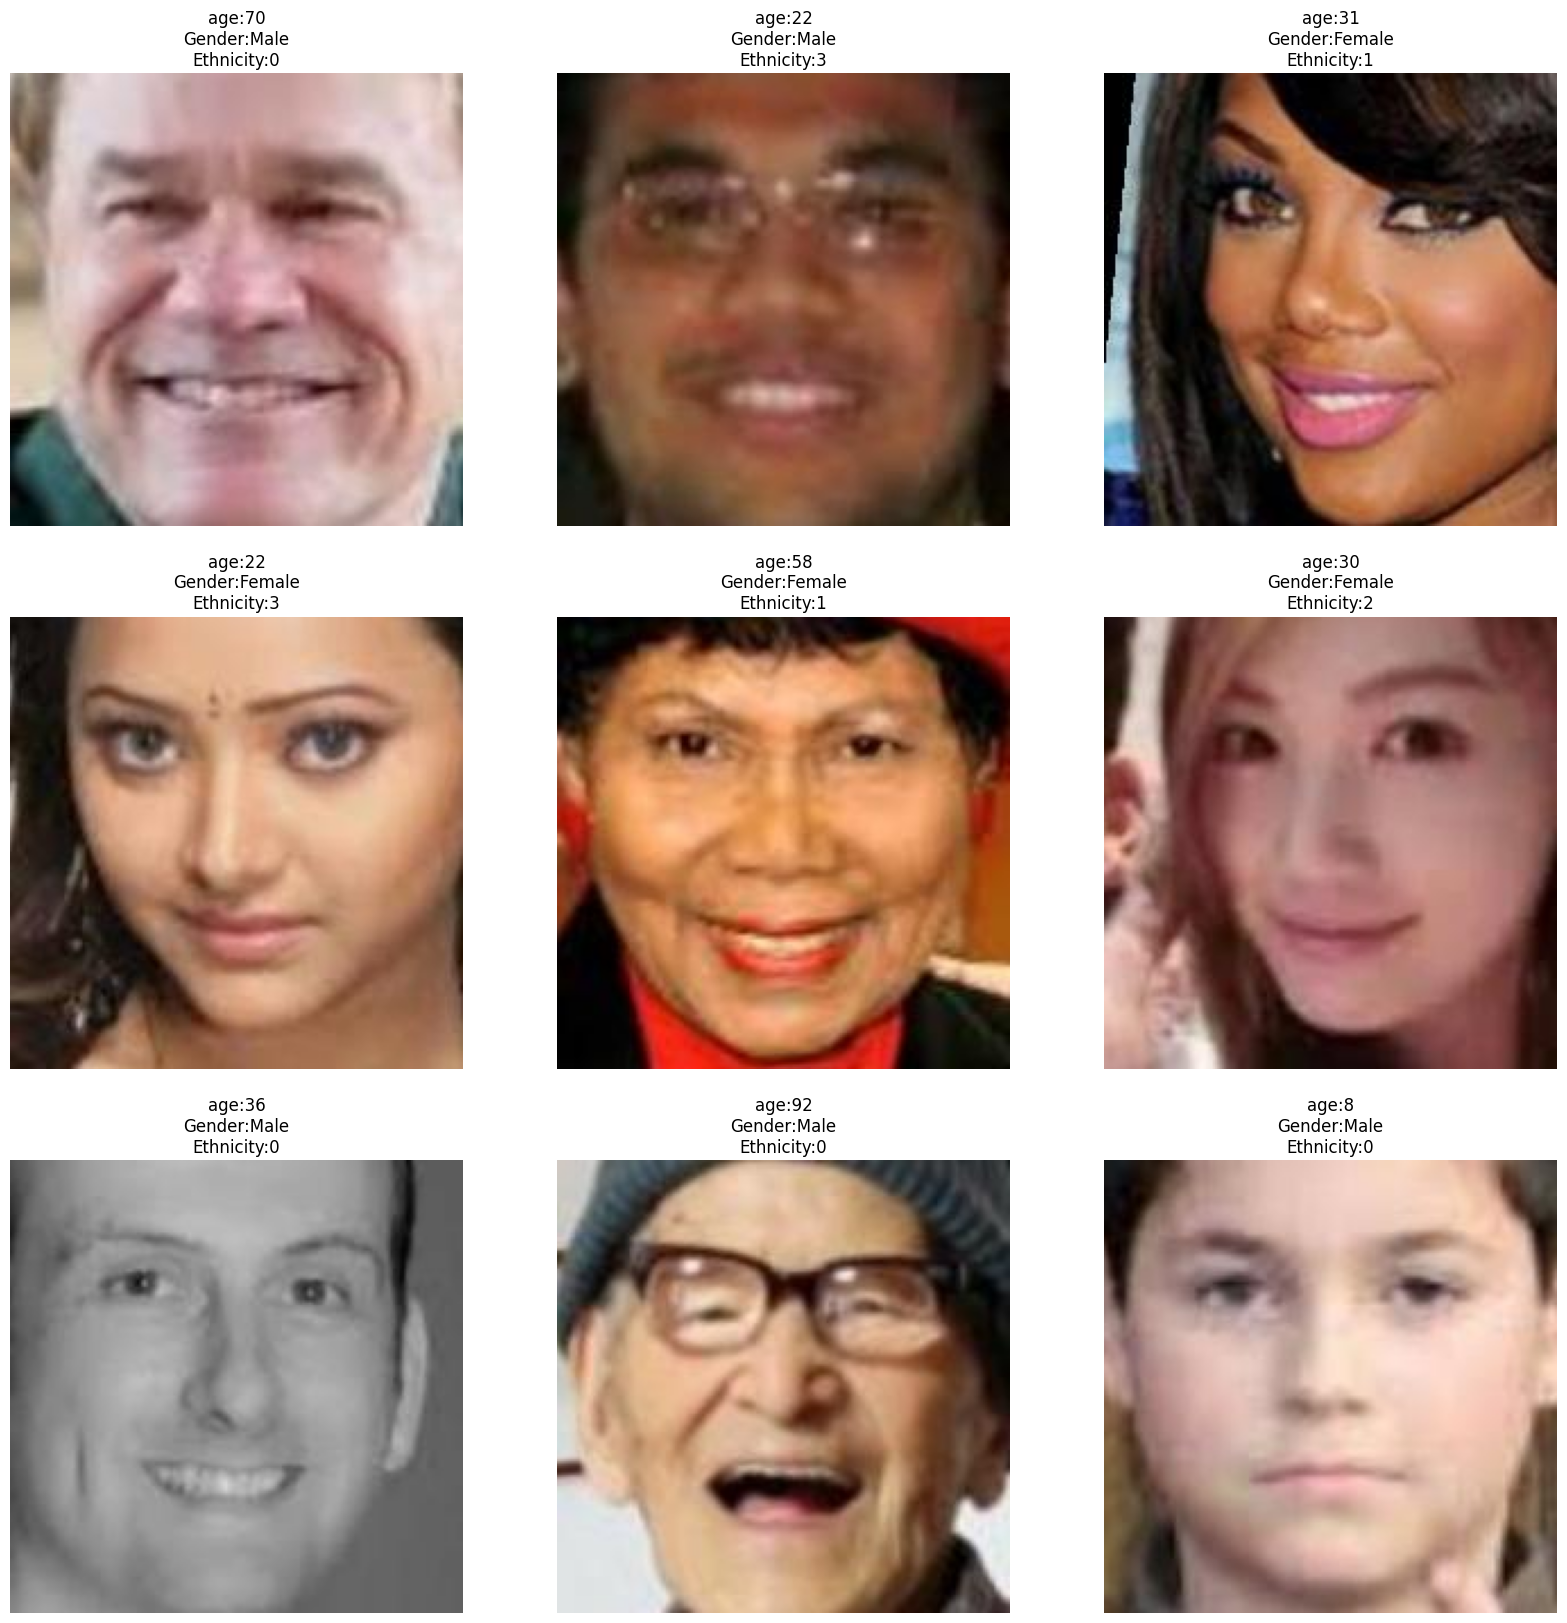

In [10]:
dataset_folder='/content/utkface_aligned_cropped/UTKFace'

def show_random_samples(num_samples=9):
  image_files=os.listdir(dataset_folder)
  selected_image_files=random.sample(image_files,num_samples)

  plt.figure(figsize=(20,20))
  for idx,image_file in enumerate(selected_image_files,1):
    image_path=os.path.join(dataset_folder,image_file)
    age,gender,ethnicity=image_file.split('_')[:3]

    image=Image.open(image_path)

    gender='Male'if int(gender)==0 else 'Female'
    eethnicity=['White','Black','Asian','Indian','Others'][int(ethnicity)]

    plt.subplot(3,3,idx)
    plt.imshow(image)
    plt.title(f"age:{age}\nGender:{gender}\nEthnicity:{ethnicity}")
    plt.axis('off')
plt.tight_layout()
plt.show()

show_random_samples()

###  Create a csv file which contains labels

In [11]:
dataset_dir='/content/utkface_aligned_cropped/UTKFace'
image_names=[]
ages=[]
genders=[]
ethnicities=[]
for filename in (os.listdir(dataset_dir)):
  if not filename.endswith('.jpg'):
    continue
  parts=filename.split('_')
  if len(parts)<4:
    print(filename)
    continue

  age=int(parts[0])
  gender='Male' if int(parts[1])==0 else 'Female'
  ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]
  if age>80:
    continue
  image_names.append(filename)
  ages.append(age)
  genders.append(gender)
  ethnicities.append(ethnicity)
data={'image_name':image_names,'age':ages,'gender':genders,'ethnicity':ethnicities}
df=pd.DataFrame(data)
df.to_csv('/content/utkface_data.csv',index=False)




61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg
39_1_20170116174525125.jpg.chip.jpg


###  Plot histogram for age

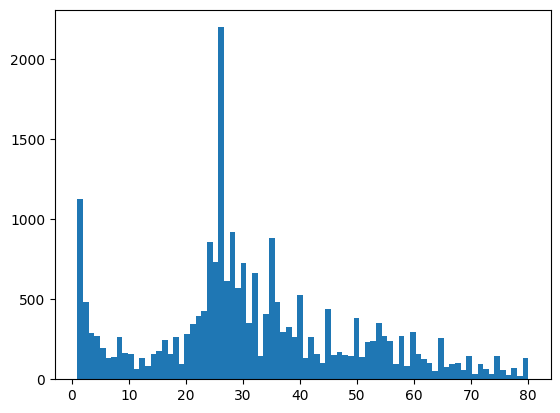

In [12]:
plt.hist(df.age,bins=len(df.age.unique()));


In [13]:
df.age.describe()

,age
count,23165.000000
mean,32.024218
std,18.227409
min,1.000000
25%,23.000000
50%,29.000000
75%,42.000000
max,80.000000


###  Plot histogram for gender

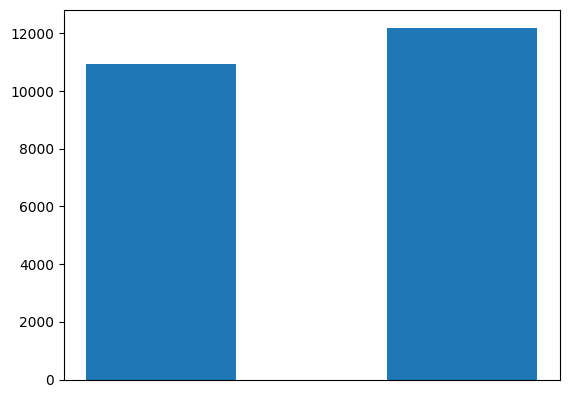

In [14]:
plt.hist(df.gender,bins=2,rwidth=0.5);

In [15]:
df.gender.value_counts()

,count
gender,
Male,12208
Female,10957


###  Plot histogram for ethnicity

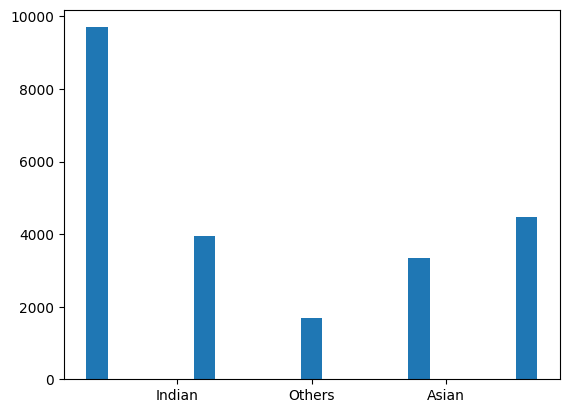

In [16]:
plt.hist(df.ethnicity,bins=5,rwidth=0.2);

In [17]:
df.ethnicity.value_counts()

,count
ethnicity,
White,9698
Black,4478
Indian,3952
Asian,3348
Others,1689


###  Calculate the cross-tabulation of gender and ethnicity using the pandas.crosstab() function.

In [18]:
pd.crosstab(index=df.gender,columns=df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


###  Create violin plots and box plots for age, separately for men and women.

<ipython-input-19-d2ec539acbc2>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.age[df. gender==cat]for cat  in df.gender.unique()],vert=False,labels=df.gender.unique());


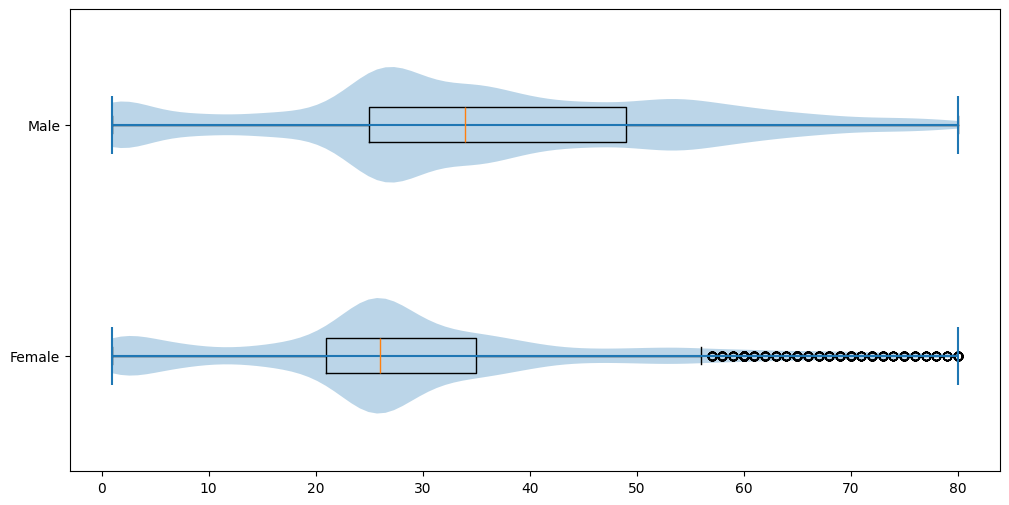

In [19]:
plt.figure(figsize=(12,6))
plt.boxplot([df.age[df. gender==cat]for cat  in df.gender.unique()],vert=False,labels=df.gender.unique());
plt.violinplot([df.age[df. gender==cat]for cat  in df.gender.unique()],vert=False);

###  Create violin plots and box plots for age, separately for each ethnicity.

<ipython-input-20-886a9eee5819>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.age[df. ethnicity==cat]for cat  in df.ethnicity.unique()],vert=False,labels=df.ethnicity.unique());


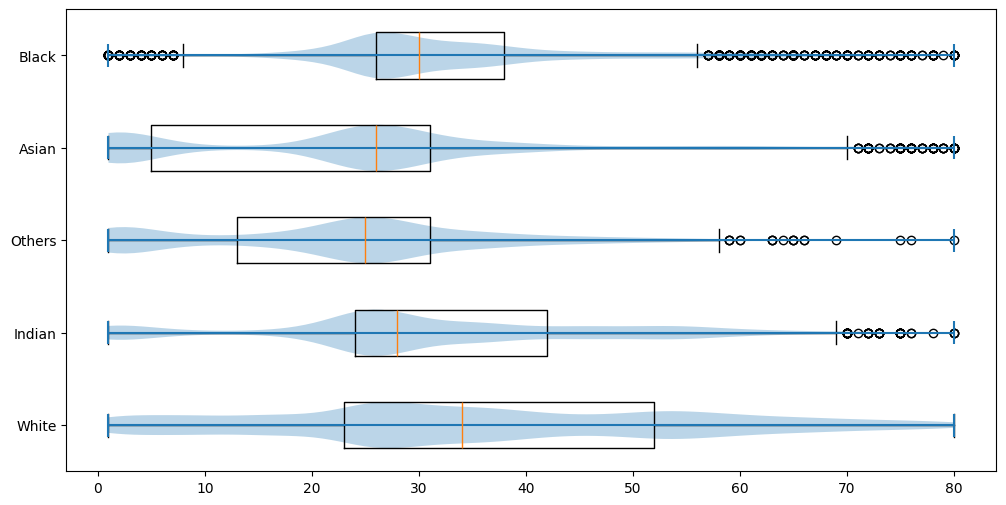

In [20]:
plt.figure(figsize=(12,6))
plt.boxplot([df.age[df. ethnicity==cat]for cat  in df.ethnicity.unique()],vert=False,labels=df.ethnicity.unique());
plt.violinplot([df.age[df. ethnicity==cat]for cat  in df.ethnicity.unique()],vert=False);

##  Split datasets

In [21]:
df_train,temp=train_test_split(df,test_size=0.3,stratify=df.age,random_state=42)
df_valid,df_test=train_test_split(temp,test_size=0.5,stratify=temp.age,random_state=42)
df_train.shape,df_valid.shape,df_test.shape

((16215, 4), (3475, 4), (3475, 4))

###  Save the training, validation, and test sets in separate CSV files.

In [22]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## Define transformations

In [23]:
train_transform=transforms.Compose([transforms.Resize((128,128)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(15),
                                   transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.1),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
test_transform=transforms.Compose([transforms.Resize((128,128)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

##  Custom dataset

In [24]:
class UTKFace(Dataset):
  def __init__(self,root_dir,csv_file,transform=None):
    self.csv_file=csv_file
    self.root_dir=root_dir
    self.transform=transform
    self.data=pd.read_csv(csv_file)
    self.gender_dict={'Male':0,'Female':1}

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    sample=self.data.iloc[idx,:]
    image_name=sample.image_name
    image=Image.open(os.path.join(self.root_dir,image_name))
    image=self.transform(image)
    age=torch.tensor([sample.age],dtype=torch.float32)
    gender=torch.tensor(self.gender_dict[sample.gender],dtype=torch.int32)
    ethnicity=sample.ethnicity

    return image,age#,gender,ethnicity

In [25]:
dataset_dir='/content/utkface_aligned_cropped/UTKFace'

train_set=UTKFace(dataset_dir,'/content/train_set.csv',train_transform)
valid_set=UTKFace(dataset_dir,'/content/valid_set.csv',test_transform)
test_set=UTKFace(dataset_dir,'/content/test_set.csv',test_transform)

🔰 Plot a few images to verify the functionality of the dataset objects.

In [26]:
img,age=train_set[2000]
img

tensor([[[-2.1179, -2.1179, -1.4672,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -1.5185,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -1.5357,  ..., -1.8097, -1.2274, -0.9877],
         ...,
         [-1.0733, -1.0904, -1.0904,  ..., -1.2445, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -1.2617, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -1.2617, -2.1179, -2.1179]],

        [[-2.0357, -2.0357,  0.3978,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357,  0.3803,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357,  0.3978,  ..., -0.8627, -0.0749,  0.3627],
         ...,
         [ 0.7479,  0.7829,  0.8529,  ...,  0.6954, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ...,  0.6954, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ...,  0.6954, -2.0357, -2.0357]],

        [[-1.8044, -1.8044,  0.7751,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044,  0.7402,  ..., -1

##  Define dataloader

🔰 Write dataloaders for the training, validation, and test sets.

In [27]:
train_loader=DataLoader(train_set,batch_size=128,shuffle=True)
valid_loader=DataLoader(valid_set,batch_size=256,shuffle=False)
test_loader=DataLoader(test_set,batch_size=256,shuffle=False)

🔰 Test the dataloaders using `next(iter())`

In [28]:
train_iter=iter(train_loader)
next(train_iter)

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

#  **Model**

In [29]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model=models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc=nn.Linear(in_features=2048,out_features=1,bias=True)

  def forward(self, x):
    y=self.model(x)
    return y

In [30]:
model=AgeEstimationModel()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


#  **Config**

In [31]:
device='cuda'if torch.cuda.is_available() else 'cpu'
model=model.to(device)

In [32]:
loss_fn=nn.L1Loss()

In [33]:
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=1e-4)

In [34]:
metric=tm.MeanAbsoluteError().to(device)

#  **Train**

In [35]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [ ]:
train_one_epoch(model,train_loader,loss_fn,optimizer,metric,epoch=1)

#  Evaluation

🔰Write the evaluation function.

In [37]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval=AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs , targets in valid_loader:
      inputs=inputs.to(device)
      targets=targets.to(device)

      outputs=model(inputs)

      loss=loss_fn(outputs,targets)

      loss_eval.update(loss.item())
      metric.update(outputs,targets)
    return loss_eval.avg,metric.compute().item()

#  Training Process

##  Finding Hyper-parameters

###   Calculate the loss for an untrained model using a few batches.


In [38]:
model=AgeEstimationModel()
inputs,targets=next(iter(train_loader))
inputs=inputs.to(device)
targets=targets.to(device)

with torch.no_grad():
  outputs=model(inputs)
  loss=loss_fn(outputs,targets)

print(loss)

tensor(29.7331)


###   Try to train and overfit the model on a small subset of the dataset.

In [39]:
mini_train_size=1000
_,mini_train_dataset=random_split(train_set,(len(train_set)-mini_train_size,mini_train_size))
mini_train_loader=DataLoader(mini_train_dataset,20)

In [40]:
model=AgeEstimationModel()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.9)

###   Train the model for a limited number of epochs, experimenting with various learning rates.

In [41]:
num_epochs=3

for lr in [0.1,0.01,0.001,0.0001]:
  print(f'lr={lr}')
  model=AgeEstimationModel()
  optimizer=torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.9)
  for epoch in range(num_epochs):
    model,_,_=train_one_epoch(model,mini_train_loader,loss_fn,optimizer,metric,epoch)

print()


lr=0.1


Epoch 2:   8%|▊         | 4/50 [00:15<02:58,  3.89s/batch, loss=14.1, metric=14.1]


KeyboardInterrupt: 

###   Main Loop





In [42]:
model=AgeEstimationModel().to(device)

In [43]:
optimizer=optim.SGD(model.parameters(),lr=0.001,weight_decay=1e-4,momentum=0.9)

In [44]:
loss_train_history=[]
loss_valid_history=[]

metric_train_hist=[]
metric_valid_hist=[]

best_loss_valid=torch.inf
epoch_counter=0

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
  model,loss_train,metric_train=train_one_epoch(model,train_loader,loss_fn,optimizer,metric,epoch)

  loss_valid,metric_valid=evaluate(model,valid_loader,loss_fn,metric)

  loss_train_history.append(loss_train)
  loss_valid_hastory.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid<best_loss_valid:
    torch.save(model,f'model.pt')
    best_loss_valid=loss_valid
    print('model saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

 43%|████▎     | 55/127 [29:36<37:06, 30.93s/batch, loss=24, metric=24]    

##  Plot

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#  **Test**

In [ ]:
model_path='/content/model.pt'
model=torch.load(model_path)
model.eval()


In [ ]:
_,metric_train=evaluate(model,train_loader,loss_fn.metric)
_,metric_valid=evaluate(model,valid_loader,loss_fn.metric)
_,metric_test=evaluate(model,test_loader,loss_fn.metric)

metric_train,metric_valid,metric_test

#  **Inference**

In [ ]:
!cp /content/drive/MyDrive/deep-catalyst/project_0-age_estimation/model.pt /content/

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
!pip install face-recognition

In [ ]:
import face_recognition

In [ ]:
def inference(image_path, transform, model, face_detection=False):
  if face_detection:
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_crop = img[top:bottom, left:right]
    img_crop = Image.fromarray(img_crop)
  else:
    img_crop = Image.open(image_path).convert('RGB')

  img_tensor = transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds = model(img_tensor.to(device)).item()

  return preds, img_crop

In [ ]:
preds, img = inference('/content/sample.jpg',
          test_transform, model, face_detection=True)

print(f'{preds:.2f}')
img

In [ ]:
# Load a random image from a folder
folder_image_path = '/content/UTKFace/'
image_files = os.listdir(folder_image_path)

rand_idx = random.randint(0, len(image_files))
test_image_path = os.path.join(folder_image_path, image_files[rand_idx])
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = image_files[rand_idx].split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

In [ ]:
# Load a random image from a casv file
csv_file_path = '/content/test_set.csv'
df = pd.read_csv(csv_file_path)

rand_idx = random.randint(0, df.shape[0])
test_image_name = df.iloc[rand_idx].image_name
test_image_path = os.path.join(folder_image_path, test_image_name)
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image